# FRGC Clustering with RetinaFace + ArcFace

## 0. Setup

In [1]:
import os
import numpy as np
import cv2
from insightface.app import FaceAnalysis
from tqdm import tqdm
import pandas as pd
from joblib import Parallel, delayed

In [2]:
os.environ['CUDA_VISIBLE_DEVICES'] = '0,1' #use both GPU

## 1. Load FRGC dataset

In [3]:
FRGC_root = '/d1/jferna27/FRGC-nd1/all'
csv_path = '../frgc cluster/frgc_face_embeddings.csv'

if os.path.exists(csv_path): # CSV found, load from it
    print(f"Found {csv_path}, person ids loaded from csv")
    df = pd.read_csv(csv_path) #df.columns: 512d,image_file,, person_id
    image_files = df['image_file'].tolist()
    print(f"Total images: {len(image_files)}")
    person_ids = df['person_id'].tolist()  #person_id column from CSV
    unique_persons = sorted(list(set(person_ids)))
    print(f"Identities: {len(unique_persons)}")
    csv_pids = set(df['person_id'].tolist())

else: # CSV not found, use FRGC_root directory scan
    image_files = [f for f in os.listdir(FRGC_root) if f.endswith('.JPG') or f.endswith('.jpg')]
    print(f"Total images: {len(image_files)}")
    person_ids = [img[:5] for img in image_files] #person id (1st 5 characters)
    unique_persons = sorted(list(set(person_ids)))
    print(f"Identities: {len(unique_persons)}")
    

Found ../frgc cluster/frgc_face_embeddings.csv, person ids loaded from csv
Total images: 39327
Identities: 568


## 2. Initialize Face Detection + Embeddings

## 3. Extract embeddings (parallel processing on both GPUs)

In [4]:
if os.path.exists(csv_path): #use csv if exists
    print("Found frgc_face_embeddings.csv")
    df = pd.read_csv(csv_path)
    drop_cols = ['image_file', 'person_id']
    emb_cols = [c for c in df.columns if c not in drop_cols]
    embeddings = df[emb_cols].values
    valid_person_ids = df['person_id'].tolist()  # Use person_id directly
    valid_image_files = df['image_file'].tolist()

else: #csv does not exist, process images to extract embeddings
    print(f"Processing with GPU 0 and 1")
    def process_batch_worker(gpu_id, batch_data):
        app = FaceAnalysis(name="buffalo_l")
        app.prepare(ctx_id=gpu_id, det_size=(160, 160))
        embs, pids, files = [], [], []
        for img_file, pid in tqdm(batch_data, desc=f"GPU {gpu_id}"):
            img = cv2.imread(os.path.join(FRGC_root, img_file))
            if img is not None:
                faces = app.get(img)
                if len(faces) > 0:
                    embs.append(faces[0].embedding)
                    pids.append(pid)
                    files.append(img_file)
        return {'embs': embs, 'pids': pids, 'files': files}
    
    person_ids_list = [img[:5] for img in image_files]
    mid = len(image_files) // 2
    results = Parallel(n_jobs=2, backend='loky')(
        delayed(process_batch_worker)(gpu_id, list(zip(image_files[start:end], person_ids_list[start:end])))
        for gpu_id, (start, end) in [(0, (0, mid)), (1, (mid, len(image_files)))]
    )
    embeddings = np.vstack([np.array(r['embs']) for r in results])
    valid_person_ids = sum([r['pids'] for r in results], [])
    valid_image_files = sum([r['files'] for r in results], [])

print(f"Embeddings: {embeddings.shape}")
print(f"Valid images: {len(valid_image_files)}")
print(f"Unique person_ids: {len(set(valid_person_ids))}")

Found frgc_face_embeddings.csv
Embeddings: (39327, 512)
Valid images: 39327
Unique person_ids: 568


In [5]:
if os.path.exists(csv_path):
    print(f"{csv_path} already exists.")
else: #save csv
    embeddings_df = pd.DataFrame(embeddings)
    embeddings_df['person_id'] = valid_person_ids
    embeddings_df['image_file'] = valid_image_files
    embeddings_df.to_csv('frgc_face_embeddings2.csv', index=False)
    print(f"Embeddings and person_ids saved to 'frgc_face_embeddings2.csv'")

../frgc cluster/frgc_face_embeddings.csv already exists.


## 4. Cluster by identity

In [6]:
labels_arr = np.array(valid_person_ids)  # array of person_ids
unique_ids = np.unique(labels_arr)  # unique person ids
counts = {pid: int((labels_arr == pid).sum()) for pid in unique_ids}
min_imgs = 100
keep_ids = [pid for pid, c in counts.items() if c >= min_imgs]
print(f"Identities with >= {min_imgs} images: {len(keep_ids)}/{len(unique_ids)}")

mask = np.isin(labels_arr, keep_ids)
labels_arr = labels_arr[mask]
embeddings = embeddings[mask]
valid_person_ids = labels_arr.tolist()
unique_ids = np.unique(labels_arr)

identity_indices = {pid: np.where(labels_arr == pid)[0] for pid in unique_ids}  # map person_id to indices
identity_clusters = {pid: embeddings[idxs] for pid, idxs in identity_indices.items()}  # map person_id to embeddings

Identities with >= 100 images: 142/568


In [7]:
cluster_stats = {}
for pid, cluster in identity_clusters.items():
    centroid = cluster.mean(axis=0)
    distances = np.linalg.norm(cluster - centroid, axis=1)
    cluster_stats[pid] = {
        "centroid": centroid,
        "radius": float(distances.max()),
        "dispersion": float(distances.std()),
        "num_images": int(len(cluster))
    }

In [8]:
print(cluster_stats)

{2463: {'centroid': array([ 1.36079760e+00, -5.53617906e-01,  8.19623687e-01, -5.97872120e-01,
        7.04318322e-01,  6.38033939e-01, -2.29981774e-02,  7.24419654e-01,
        1.26011928e+00,  6.89536185e-01, -4.32604623e-01,  4.37730998e-01,
       -9.29212914e-01, -1.88015310e-01,  2.98649382e-01,  1.77353284e-02,
        2.62412907e-02,  1.93048870e-02, -2.61366673e-01,  6.01749572e-01,
       -4.30036073e-02, -1.51317886e+00,  1.53724335e+00, -1.48630439e-01,
        2.90227277e-01, -4.13044099e-01,  9.34751462e-01,  1.05606430e+00,
       -1.50293793e+00, -1.18616631e+00, -4.88096725e-01,  5.07334496e-02,
        1.39240670e-01,  6.09696958e-01, -9.55037789e-02, -9.25457512e-01,
       -1.76883396e+00, -1.88725922e-01,  5.79524863e-01,  1.51770896e+00,
       -1.15441726e+00,  1.01814885e+00,  7.52622860e-03, -8.39216265e-01,
        2.34194277e-01,  1.56428035e-01, -1.26693369e-01,  7.43600427e-01,
        6.68994034e-01, -1.41671365e+00, -6.81525315e-01, -3.96701126e-01,
     

## 5. Manifold Distances

In [9]:
import importlib
import mmd_pipeline
importlib.reload(mmd_pipeline)

from mmd_pipeline import (compute_mmd_detailed, build_patch_set, recursive_split, build_distance_matrix)
from sklearn.decomposition import PCA

In [10]:
person_ids_list = list(identity_clusters.keys())
manifold_data = {}

print("manifold properties for all person_ids...")
for person_id, cluster in identity_clusters.items():
    #patches to manifold decomposition of paper per person_id
    patches_idx = recursive_split(cluster, delta_thresh=1.1, k=10)
    patches = build_patch_set(cluster, patches_idx, var_threshold=0.95)
    
    #intrinsic dimension (95% variance)
    pca = PCA(n_components=min(0.95, cluster.shape[0], cluster.shape[1]))
    pca.fit(cluster)
    cumvar = np.cumsum(pca.explained_variance_ratio_)
    intrinsic_dim = int(np.searchsorted(cumvar, 0.95)) + 1
    
    #patch statistics
    patch_sizes = [len(idx) for idx in patches_idx]
    patch_dims = [p[1].shape[1] for p in patches]
    manifold_data[person_id] = {
        'patches': patches,
        'num_patches': len(patches),
        'patch_sizes': patch_sizes,
        'patch_dims': patch_dims,
        'intrinsic_dim': intrinsic_dim,
        'avg_patch_size': np.mean(patch_sizes),
        'avg_patch_dim': np.mean(patch_dims) if patch_dims else 0,
    }

print(f"{len(manifold_data)} person_ids processed")

manifold properties for all person_ids...
142 person_ids processed


In [11]:
#MMD distances for all person_id pairs
mmd_results = {}
total_pairs = len(person_ids_list) * (len(person_ids_list) - 1) // 2 # C(n,2)= n(n-1)/2
pair_count = 0

print(f"MMD between {total_pairs} person_id pairs...")
for i in range(len(person_ids_list)):
    for j in range(i+1, len(person_ids_list)):
        pair_count += 1

        try:
            pid_i, pid_j = person_ids_list[i], person_ids_list[j]    
            #precomputed patches
            patchesA = manifold_data[pid_i]['patches']
            patchesB = manifold_data[pid_j]['patches']
            #distance matrix and compute MMD
            D = build_distance_matrix(patchesA, patchesB)
            if D.size > 0:
                mmd_dist, mmd_info = compute_mmd_detailed(D, patchesA, patchesB)
                mmd_results[(pid_i, pid_j)] = {'distance': mmd_dist, 'info': mmd_info}
            else:
                print("none")
                mmd_results[(pid_i, pid_j)] = {'distance': None, 'info': None}
        except Exception as e:
            print("Exception: ", e)
            mmd_results[(pid_i, pid_j)] = {'distance': None, 'info': None}

valid = sum(1 for v in mmd_results.values() if v['distance'] is not None)
print(f"Completed: {valid}/{len(mmd_results)} pairs computed successfully")

MMD between 10011 person_id pairs...
Completed: 10011/10011 pairs computed successfully


In [12]:
mmd_data = []
for (pid_i, pid_j), result in mmd_results.items():
    if result['distance'] is not None:
        mmd_info = result['info']
        data_i = manifold_data[pid_i]
        data_j = manifold_data[pid_j]
        
        mmd_data.append({
            'person_id_A': pid_i,
            'person_id_B': pid_j,
            'intrinsic_dim_A': data_i['intrinsic_dim'],
            'intrinsic_dim_B': data_j['intrinsic_dim'],
            'num_patches_A': data_i['num_patches'],
            'num_patches_B': data_j['num_patches'],
            'avg_patch_dim_A': data_i['avg_patch_dim'], 
            'avg_patch_dim_B': data_j['avg_patch_dim'],
            'avg_patch_size_A': data_i['avg_patch_size'], #avg size of patches, number of imgs/embeddings per patch
            'avg_patch_size_B': data_j['avg_patch_size'],
            'mmd_distance': result['distance'],
            'num_matches': len(mmd_info['matches']), #number of correspondence unique found between the patches of the 2 manifolds with NN'S NN
            'mean_match_dim': mmd_info['mean_pair_dim'],
            'median_match_dim': mmd_info['median_pair_dim'],
            'matches': mmd_info['matches']
        })

mmd_df = pd.DataFrame(mmd_data)

#Summary
print(f"Total valid pairs: {len(mmd_df)}")
print(f"\n{'─'*60}")

print(f"MMD Distance: min={mmd_df['mmd_distance'].min():.4f}, max={mmd_df['mmd_distance'].max():.4f}, mean={mmd_df['mmd_distance'].mean():.4f}")
print(f"Num Patches: A={mmd_df['num_patches_A'].mean():.1f}±{mmd_df['num_patches_A'].std():.1f}, B={mmd_df['num_patches_B'].mean():.1f}±{mmd_df['num_patches_B'].std():.1f}")
print(f"Avg Patch Dim: A={mmd_df['avg_patch_dim_A'].mean():.1f}±{mmd_df['avg_patch_dim_A'].std():.1f}, B={mmd_df['avg_patch_dim_B'].mean():.1f}±{mmd_df['avg_patch_dim_B'].std():.1f}")
print(f"Num Matches: mean={mmd_df['num_matches'].mean():.1f} (min={mmd_df['num_matches'].min()}, max={mmd_df['num_matches'].max()})")
print(f"{'─'*60}")

print(f"\nTop 5 closest pairs (smallest MMD):")
print(mmd_df.nsmallest(5, 'mmd_distance')[['person_id_A', 'person_id_B', 'mmd_distance', 'num_patches_A', 'num_patches_B']].to_string(index=False))
print(f"\nTop 5 farthest pairs (largest MMD):")
print(mmd_df.nlargest(5, 'mmd_distance')[['person_id_A', 'person_id_B', 'mmd_distance', 'num_patches_A', 'num_patches_B']].to_string(index=False))

Total valid pairs: 10011

────────────────────────────────────────────────────────────
MMD Distance: min=1.2532, max=1.3816, mean=1.3454
Num Patches: A=2.9±1.0, B=2.8±0.9
Avg Patch Dim: A=36.2±8.7, B=34.8±9.0
Num Matches: mean=1.7 (min=1, max=5)
────────────────────────────────────────────────────────────

Top 5 closest pairs (smallest MMD):
 person_id_A  person_id_B  mmd_distance  num_patches_A  num_patches_B
        4217         4557      1.253165              2              3
        4221         4633      1.269423              2              3
        4221         4559      1.270339              2              2
        4575         4708      1.271080              4              1
        4429         4575      1.278865              2              4

Top 5 farthest pairs (largest MMD):
 person_id_A  person_id_B  mmd_distance  num_patches_A  num_patches_B
        4463         4745      1.381637              5              3
        4463         4727      1.380766              5     

In [25]:
# Distance matrix for all identities
id_to_idx = {pid: i for i, pid in enumerate(person_ids_list)}
n = len(person_ids_list)
dist_mat = np.full((n, n), np.nan)

for _, row in mmd_df.iterrows():
    i = id_to_idx[row['person_id_A']]
    j = id_to_idx[row['person_id_B']]
    dist_mat[i, j] = row['mmd_distance']
    dist_mat[j, i] = row['mmd_distance']


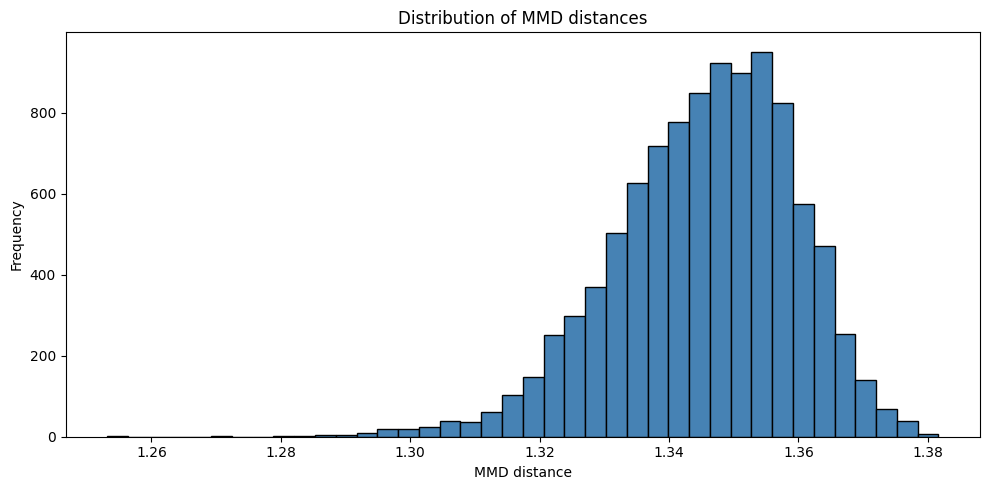

In [26]:
# Histogram of MMD distances
plt.figure(figsize=(10, 5))
plt.hist(mmd_df['mmd_distance'], bins=40, color='steelblue', edgecolor='black')
plt.title('Distribution of MMD distances')
plt.xlabel('MMD distance')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()


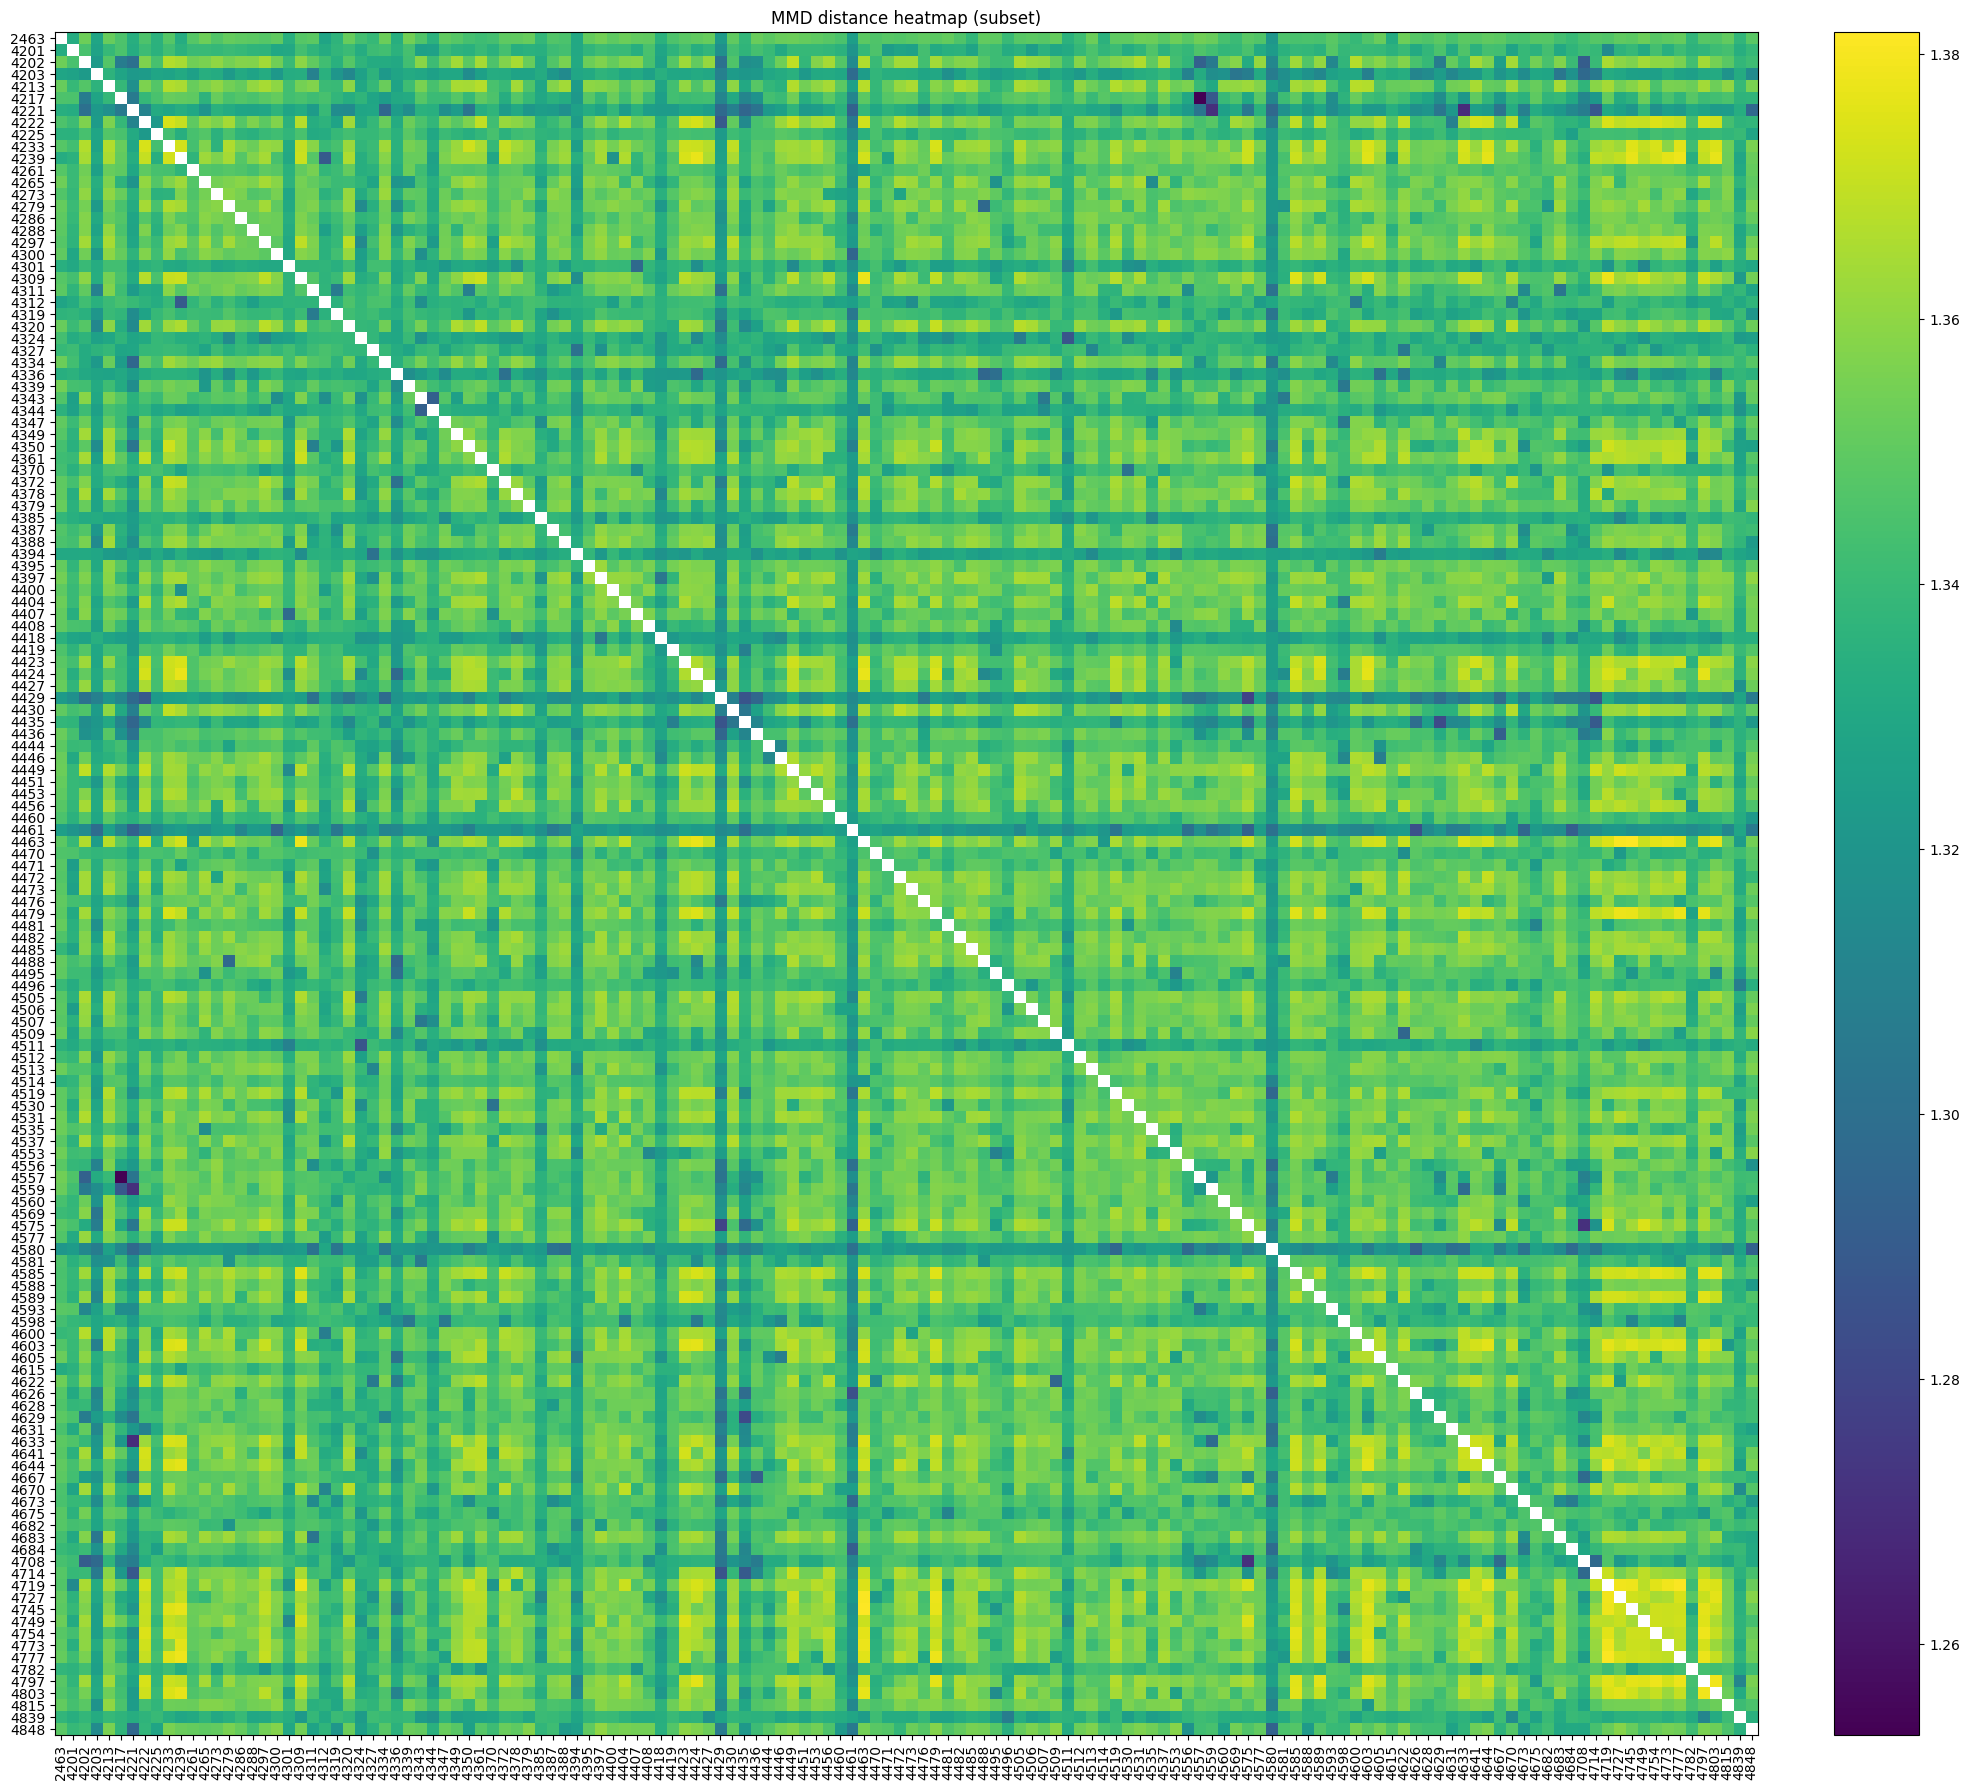

In [27]:
# Heatmap of distances (subset)
plt.figure(figsize=(20, 18))
im = plt.imshow(dist_mat, cmap='viridis')
plt.title('MMD distance heatmap (subset)')
plt.xticks(range(n), person_ids_list, rotation=90)
plt.yticks(range(n), person_ids_list)
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.tight_layout()
plt.show()
